# Füllstandsregelung

In [1]:
using Plots, ControlSystems, Interact

┌ Info: Precompiling Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1186


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-13319489940249274099\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-7448532843137353522\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/fe0cb2aefd664306669a5b7d7c1ae70e352f84d0-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-13319489940249274099\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

<img src="images/bsb_fuellstandsregelung.svg" style="margin: auto; width: 40%;"/>

Differentialgleichung des Behälters:
\begin{align}
    \frac{dV}{dt} &= q_\mathrm{in}(t)-q_\mathrm{out}(t) \\
    \frac{dy}{dt} &= \frac{1}{A} \left(u(t)-q_\mathrm{out}(t)\right)
\end{align}
Laplace-Transformation
\begin{align}
    sY(s) &= \frac{1}{A} ( U(s)-Q_\mathrm{out}(s))
\end{align}
Der Ausfluss wird als Störung modelliert.
Damit ist die Übertragungsfunktion der Regelstrecke (wir betrachten nicht die Störung)
\begin{align}
    G(s) &= \frac{Y^*(s)}{U(s)} = \frac{1}{As}
\end{align}
und die Störung
\begin{align}
    D(s) &= G(s) Q_\mathrm{out}(s) = \frac{1}{As} Q_\mathrm{out}(s)
\end{align}


In [2]:
# Parameter Fläche
A = 1.0

1.0

## Regelstrecke mit Störung und ohne Regelung
Einlassventil durchgängig geöffnet (Füllen des Behälters), Auslassventil nach Hälfte der Simulationszeit geöffnet (Plateau, Ein- und Auslauf im Gleichgewicht).

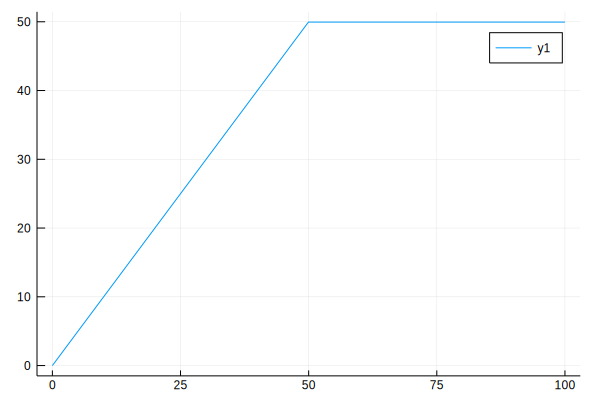

In [14]:
#pyplot() # with GR it does not work in the juliabox
gr()
B = Array{Float64}(undef,1,2)
B[1] = 1/A; B[2] = -1/A
G_mitstoerung = ss(0,B,1,0)
# Simulation mit Öffnen der Ventile
tspan = range(0.0,stop=100.0,length=1000)
u = zeros(length(tspan),2)
u[:,1] .= 1.0
u[500:end,2] .= 1.0
y,t,x = lsim(G_mitstoerung,u,tspan)
plot(t,y)

## Regelstrecke mit Störung und mit Regelung (PI)
Sollwertregelung mit Störung (Öffnen des Auslassventils) nach Hälfte der Simulationszeit.

Wir machen das von Hand.
Für die Feedback-Schleife mit Regler haben wir dann
\begin{align*}
    Y(s) &= \frac{K(s)G(s)}{1+K(s)G(s)}W(s)-\frac{G(s)}{1+K(s)G(s)}Q_\mathrm{out}(s)
\end{align*}

In [34]:
GG = tf(G_mitstoerung) # Übertragungsfunktion aus Zustandsraummodell
s = tf("s")
u[:,1] .= 10.0 # Sollwert
@manipulate for kp=0:0.025:1, ki=0:0.025:1
    K = kp + ki/s # PI-Regler
    #=
    Folgendes ist nicht möglich, da MIMO-Inversion noch nicht implementiert ist (siehe letzte Code-Zeile).
    -----
    G0 = [K*GG[1,1] GG[1,2]] # funktioniert wie in MATLAB, siehe https://de.mathworks.com/help/control/examples/connecting-models.html (mit Komma würde man einen Array erstellen)
    # ansonsten gibt es auch noch die Funktionen series, parallel, append, feedback
    G0/(1+G0) # MIMO inversion is not yet implemented
    =#
    # Also berechnen wir es selbst von Hand (siehe darüber)
    G_ges = [K*GG[1,1]/(1+K*GG[1,1]) -GG[1,1]/(1+K*GG[1,1])]
    y,t,x = lsim(G_ges,u,tspan)
    plot(t,u[:,1], label="Sollgröße")
    plot!(t,y, label="Istwert")
    plot!(t,u[:,2],label="Störgröße",title="Sollwertregelung mit Störung (Öffnen des Auslassventils)",xlabel="Zeit",ylabel="Größen")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope("knockout-component-54b5a1ae-c3cb-4fe9-9a0b-a479f873e0b2", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["kp"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row-left"), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>41,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-center"), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-right"), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget"), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Any} with 2 listeners. Value:
21, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/staff/mo.schulze/.julia/packages/Knockout/JE2Yq/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/staff/mo.schulze/.julia/packages/Knockout/JE2Yq/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/staff/mo.schulze/.julia/packages/InteractBase/R8JgH/src/../assets/all.js"), Asset("css", nothing, "/home/staff/mo.schulze/.julia/packages/InteractBase/R8JgH/src/../assets/style.css"), Asset("css", nothing, "/home/staff/mo.schulze/.julia/packages/Interact/0klKX/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:9223372036854775807,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.025\",\"0.05\",\"0.075\",\"0.1\",\"0.125\",\"0.15\",\"0.175\",\"0.2\",\"0.225\",\"0.25\",\"0.275\",\"0.3\",\"0.325\",\"0.35\",\"0.375\",\"0.4\",\"0.425\",\"0.45\",\"0.475\",\"0.5\",\"0.525\",\"0.55\",\"0.575\",\"0.6\",\"0.625\",\"0.65\",\"0.675\",\"0.7\",\"0.725\",\"0.75\",\"0.775\",\"0.8\",\"0.825\",\"0.85\",\"0.875\",\"0.9\",\"0.925\",\"0.95\",\"0.975\",\"1.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"knockout-component-54b5a1ae-c3cb-4fe9-9a0b-a479f873e0b2\",\"id\":\"ob_135\",\"ty